# Bitcoin Trading Bot using Reinforcement Learning Algorithm

### Introduction

<center><img src="imgs/bitcoin 1.png" width=1200/></center>

### Let's use an AI algorithm to solve the problem.
### There are 2 algorithms that fit this problem, which are Deep Q-Learning and Double Deep Q-Learning.

<center><img src="imgs/reinforcement_learning_loop-650x294.png" width=500/></center>
<center><img src="imgs/XBsvH.png" width=500/></center>

### Design Neural Networks

<center><img src="imgs/buy network.png" width=500/> <img src="imgs/sell network.png" width=500/></center>

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
from torch import nn
from torch.nn import functional as F

In [3]:
class NNModel_Buy(nn.Module):
    def __init__(self):
        super().__init__()
        self.neural1 = nn.Linear(336, 512) # 7 days * 24 hours * (60 minutes/30 minute interval) = 336
        self.neural2 = nn.Linear(512, 512)
        self.neural3 = nn.Linear(512, 512)
        self.neural4 = nn.Linear(512, 2)

    def forward(self, x):
        h = F.relu(self.neural1(x))
        h = F.relu(self.neural2(h))
        h = F.relu(self.neural3(h))
        h = self.neural4(h)
        return h
    
model_buy_dql = NNModel_Buy().cuda()
model_buy_ddql = NNModel_Buy().cuda()

In [4]:
class NNModel_Sell(nn.Module):
    def __init__(self):
        super().__init__()
        self.neural1 = nn.Linear(336, 512)
        self.neural2 = nn.Linear(512, 512)
        self.neural3 = nn.Linear(512, 512)
        self.neural4 = nn.Linear(512, 2)

    def forward(self, x):
        h = F.relu(self.neural1(x))
        h = F.relu(self.neural2(h))
        h = F.relu(self.neural3(h))
        h = self.neural4(h)
        return h
    
model_sell_dql = NNModel_Sell().cuda()
model_sell_ddql = NNModel_Sell().cuda()

### Reward Function

<center><img src="imgs/buy.png" width=400/> <img src="imgs/sell.png" width=400/></center>

In [5]:
class BitcoinEnv():
    def step_buy(self, action):
        future_price = self.open_price[self.sp:self.sp+96] # 2 days * 24 hours * (60 minutes/30 minute interval) = 96
        future_min = np.min(future_price)
        future_max = np.max(future_price)
        current_price = self.open_price[self.sp]
        
        if action == 0:
            reward = (2/(future_min-future_max)*(current_price-future_max) - 1) * -1
        elif action == 1:
            reward = 2/(future_min-future_max)*(current_price-future_max) - 1

    def step_sell(self, action):
        future_price = self.open_price[self.sp:self.sp+96]
        future_min = np.min(future_price)
        future_max = np.max(future_price)
        current_price = self.open_price[self.sp]
        
        if action == 0:
            reward = 2/(future_min-future_max)*(current_price-future_max) - 1
        elif action == 1:
            reward = (2/(future_min-future_max)*(current_price-future_max) - 1) * -1

### Getting the Bitcoin price from Binance for a period of one year and one month with a 30 minute interval.
#### - One year for training [1 Oct, 2020 to 1 Oct, 2021]
#### - One month for validation [1 Oct, 2021 to 1 Nov, 2021]

In [6]:
from binance.client import Client
import numpy as np

In [7]:
with open('API_KEY.txt', 'r') as txtfile:
    API_KEY = txtfile.read()
    
client = Client(API_KEY[:API_KEY.find('\n')], API_KEY[API_KEY.find('\n')+1:])
his = client.get_historical_klines('BTCUSDT', Client.KLINE_INTERVAL_30MINUTE, '1 Oct, 2020', '1 Nov, 2021')
open_price = (np.array(his)[0:-1, 1]).astype(np.float32)

### Plotting Dataset

In [8]:
import matplotlib.pyplot as plt

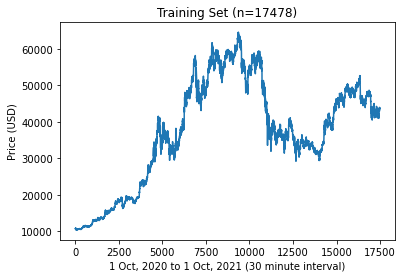

In [9]:
plt.plot(open_price[:17478])
plt.title('Training Set (n=17478)')
plt.xlabel('1 Oct, 2020 to 1 Oct, 2021 (30 minute interval)')
plt.ylabel('Price (USD)')
plt.show()

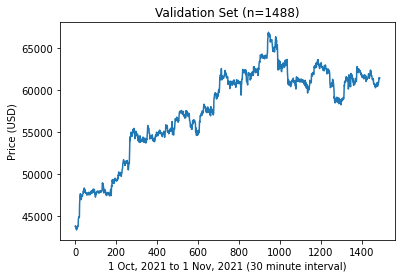

In [10]:
plt.plot(open_price[17478:])
plt.title('Validation Set (n=1488)')
plt.xlabel('1 Oct, 2021 to 1 Nov, 2021 (30 minute interval)')
plt.ylabel('Price (USD)')
plt.show()

### Standardization Dataset

<center><img src="imgs/std.png" width=180/></center>

In [11]:
# price_mean = np.mean(open_price)
# price_std = np.std(open_price)

price_mean = 39065.56
price_std = 15103.736

open_price = (open_price-price_mean)/price_std

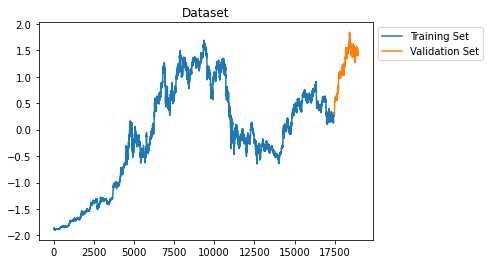

In [12]:
plt.title('Dataset')
plt.plot([n for n in range(17478)], open_price[:17478], label='Training Set')
plt.plot([n+17478 for n in range(1488)], open_price[17478:], label='Validation Set')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

### Training

<center><img src="imgs/training.png" width=1000/></center>

### Result using Deep Q-Learning

In [13]:
import pandas as pd

In [14]:
log_buy_dql = pd.read_csv('log files/deep q-learning/buy/history.csv')
log_sell_dql = pd.read_csv('log files/deep q-learning/sell/history.csv')

log_buy_dql = log_buy_dql.to_numpy()[:, -3]
log_sell_dql = log_sell_dql.to_numpy()[:, -3]

buy_dql = []
sell_dql = []
for n in range(len(log_buy_dql)):
    if ~np.isnan(log_buy_dql[n]):
        buy_dql.append(log_buy_dql[n])
    if ~np.isnan(log_sell_dql[n]):
        sell_dql.append(log_sell_dql[n])

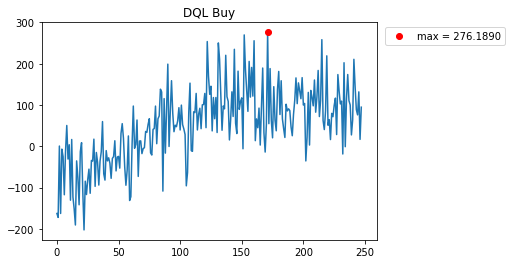

In [15]:
plt.title('DQL Buy')
plt.plot(buy_dql)
plt.plot(np.argmax(buy_dql), np.max(buy_dql), 'ro', label=f'max = {np.max(buy_dql):.4f}')
plt.legend(bbox_to_anchor=(1.4, 1))
plt.show()

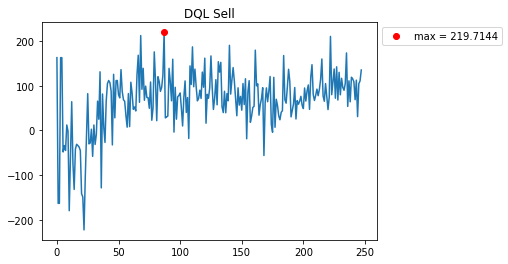

In [16]:
plt.title('DQL Sell')
plt.plot(sell_dql)
plt.plot(np.argmax(sell_dql), np.max(sell_dql), 'ro', label=f'max = {np.max(sell_dql):.4f}')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [17]:
model_buy_dql.load_state_dict(torch.load('log files/deep q-learning/buy/9_276.189041/model_buy.pth'))
model_sell_dql.load_state_dict(torch.load('log files/deep q-learning/sell/3_219.714433/model_sell.pth'))
model_buy_dql.eval()
model_sell_dql.eval()

money_start = 10000
curr_money = money_start
curr_btc = 0

buy_state = True
sell_state = False

print(' Action    Your USD      Your BTC\n')

when_buy = []
when_sell = []

with torch.no_grad():
    for n in range(1056):
        state = open_price[n+17813-335:n+17813+1]
        s = torch.FloatTensor(state).cuda()
        
        btc_price = open_price[n+17813]*price_std+price_mean

        if buy_state:
            q_values = model_buy_dql(s)
            action = torch.argmax(q_values).item()
            
            if action == 1:
                curr_btc = curr_money/btc_price
                curr_money = 0
                print(f'Buy         {curr_money:.4f}        {curr_btc:.4f}')
                buy_state = False
                sell_state = True
                when_buy.append(n)
            elif action == 0:
                print(f'Not buy     {curr_money:.4f}    {curr_btc:.4f}')
                
        elif sell_state:
            q_values = model_sell_dql(s)
            action = torch.argmax(q_values).item()
            
            if action == 1:
                curr_money = curr_btc*btc_price
                curr_btc = 0
                print(f'Sell        {curr_money:.4f}    {curr_btc:.4f}')
                buy_state = True
                sell_state = False
                when_sell.append(n)
            elif action == 0:
                print(f'Not sell    {curr_money:.4f}        {curr_btc:.4f}')

 Action    Your USD      Your BTC

Buy         0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell

In [18]:
if sell_state:
    curr_money = curr_btc*btc_price
    
print(f'Start price: {money_start} USD')
print(f'Final price: {curr_money:.4f} USD')
start_btc = money_start/(open_price[17813]*price_std+price_mean)
print(f'Final price if not using this trade bot: {start_btc*btc_price:.4f} USD')

Start price: 10000 USD
Final price: 11502.9221 USD
Final price if not using this trade bot: 11576.2171 USD


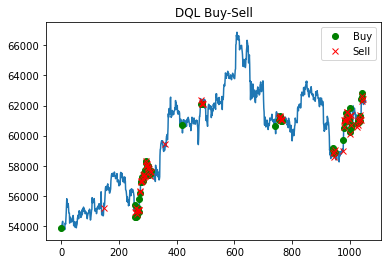

In [19]:
plt.title('DQL Buy-Sell')
price_destd = open_price*price_std+price_mean
plt.plot(price_destd[17813:1056+17813])
plt.plot(when_buy, price_destd[[np.array(when_buy)+17813]], 'go', label='Buy')
plt.plot(when_sell, price_destd[[np.array(when_sell)+17813]], 'rx', label='Sell')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

### Result using Double Deep Q-Learning

In [20]:
log_buy_ddql = pd.read_csv('log files/double deep q-learning/buy/history.csv')
log_sell_ddql = pd.read_csv('log files/double deep q-learning/sell/history.csv')

log_buy_ddql = log_buy_ddql.to_numpy()[:, -4]
log_sell_ddql = log_sell_ddql.to_numpy()[:, -4]

buy_ddql = []
sell_ddql = []
for n in range(len(log_buy_ddql)):
    if ~np.isnan(log_buy_ddql[n]):
        buy_ddql.append(log_buy_ddql[n])
    if ~np.isnan(log_sell_ddql[n]):
        sell_ddql.append(log_sell_ddql[n])

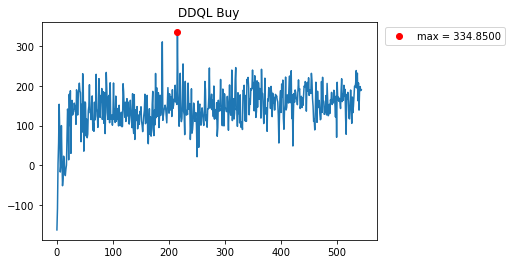

In [21]:
plt.title('DDQL Buy')
plt.plot(buy_ddql)
plt.plot(np.argmax(buy_ddql), np.max(buy_ddql), 'ro', label=f'max = {np.max(buy_ddql):.4f}')
plt.legend(bbox_to_anchor=(1.4, 1))
plt.show()

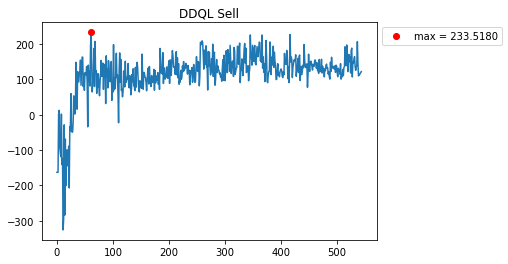

In [22]:
plt.title('DDQL Sell')
plt.plot(sell_ddql)
plt.plot(np.argmax(sell_ddql), np.max(sell_ddql), 'ro', label=f'max = {np.max(sell_ddql):.4f}')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [23]:
model_buy_ddql.load_state_dict(torch.load('log files/double deep q-learning/buy/13_334.849954/model_buy.pth'))
model_sell_ddql.load_state_dict(torch.load('log files/double deep q-learning/sell/9_233.517986/model_sell.pth'))
model_buy_ddql.eval()
model_sell_ddql.eval()

money_start = 10000
curr_money = money_start
curr_btc = 0

buy_state = True
sell_state = False

print(' Action    Your USD      Your BTC\n')

when_buy = []
when_sell = []

with torch.no_grad():
    for n in range(1056):
        state = open_price[n+17813-335:n+17813+1]
        s = torch.FloatTensor(state).cuda()
        
        btc_price = open_price[n+17813]*price_std+price_mean

        if buy_state:
            q_values = model_buy_ddql(s)
            action = torch.argmax(q_values).item()
            
            if action == 1:
                curr_btc = curr_money/btc_price
                curr_money = 0
                print(f'Buy         {curr_money:.4f}        {curr_btc:.4f}')
                buy_state = False
                sell_state = True
                when_buy.append(n)
            elif action == 0:
                print(f'Not buy     {curr_money:.4f}    {curr_btc:.4f}')
                
        elif sell_state:
            q_values = model_sell_ddql(s)
            action = torch.argmax(q_values).item()
            
            if action == 1:
                curr_money = curr_btc*btc_price
                curr_btc = 0
                print(f'Sell        {curr_money:.4f}    {curr_btc:.4f}')
                buy_state = True
                sell_state = False
                when_sell.append(n)
            elif action == 0:
                print(f'Not sell    {curr_money:.4f}        {curr_btc:.4f}')

 Action    Your USD      Your BTC

Buy         0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell    0.0000        0.1858
Not sell

In [24]:
if sell_state:
    curr_money = curr_btc*btc_price
    
print(f'Start price: {money_start} USD')
print(f'Final price: {curr_money:.4f} USD')
start_btc = money_start/(open_price[17813]*price_std+price_mean)
print(f'Final price if not using this trade bot: {start_btc*btc_price:.4f} USD')

Start price: 10000 USD
Final price: 11677.6809 USD
Final price if not using this trade bot: 11576.2171 USD


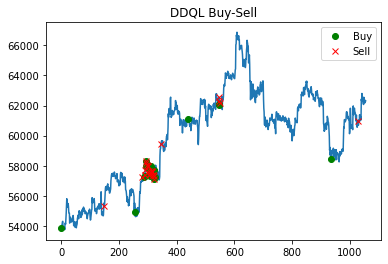

In [25]:
plt.title('DDQL Buy-Sell')
price_destd = open_price*price_std+price_mean
plt.plot(price_destd[17813:1056+17813])
plt.plot(when_buy, price_destd[[np.array(when_buy)+17813]], 'go', label='Buy')
plt.plot(when_sell, price_destd[[np.array(when_sell)+17813]], 'rx', label='Sell')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

### Recommendation
#### - Training with a shorter time interval to make it real-time trading.
#### - Training with more training set and more validation set.

#### Double Deep Q-Learning is a great algorithm for this task.

### References
#### - Liu, Y. H. (2019). PyTorch 1.x Reinforcement Learning Cookbook. Packt.